In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import leaves_list
from scipy.stats import spearmanr
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist
import pickle
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import plotly.express as px
from scipy.stats import t
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import chi2_contingency
import time
from scipy.spatial.distance import squareform
from loess.loess_1d import loess_1d
from random import sample
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
my_CB_cols = np.array(['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'])

In [3]:
np.random.seed(42)

In [4]:
base_directory = './miss-based-HC-10-10-23'

current_directory = base_directory

In [5]:
#Names of nIDPs

pickle_in = open('nIDPs.pickle','rb')

df = pickle.load(pickle_in)

X = df[1]

In [6]:
#Finding binary features

binary_feats = np.empty((X.shape[1],))

binary_feats[:] = False

for j in range(X.shape[1]):
    if np.all(np.logical_or(np.isnan(X[:,j]) , np.logical_or(X[:,j]==0 , X[:,j]==1))):
        binary_feats[j] = True

In [7]:
#Loading pre-computed correlation matrix


pickle_in = open('nIDPs_corr_mat.pickle','rb')

df = pickle.load(pickle_in)

raw_corr_mat = SimpleImputer(strategy = 'constant' , fill_value = 0).fit_transform(df[1])

In [8]:
#Loading pre-computed sample matrix, i.e., matrix of the number of pairwise complete observations

pickle_in = open('nIDPs_samp_mat.pickle','rb')

df = pickle.load(pickle_in)

sample_matrix = df[1]

In [9]:
#Loading pre-computed feature-wise distance matrix



pickle_in = open('nIDPs_dist_mat.pickle','rb')

df = pickle.load(pickle_in)

miss_based_dist = 1- df[1]/df[1].max()

In [10]:
#Complete linkage Clustering

miss_based_dist_cond = scipy.spatial.distance.squareform(miss_based_dist)

link_miss_based = linkage(miss_based_dist_cond, method='complete')

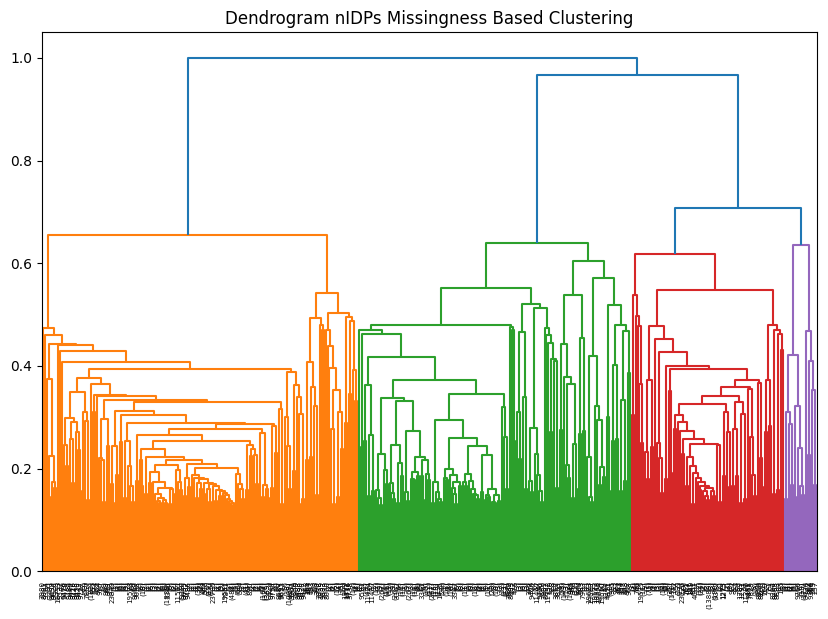

In [11]:
#Creating Dendrogram

plt.figure(figsize=(10, 7))  
plt.title("Dendrogram nIDPs Missingness Based Clustering")  
den = dendrogram(link_miss_based , p=400, truncate_mode = 'lastp')
fig = plt.gcf()
fig.savefig(base_directory + '/dendrogram.png' , bbox_inches = 'tight', dpi = 300)

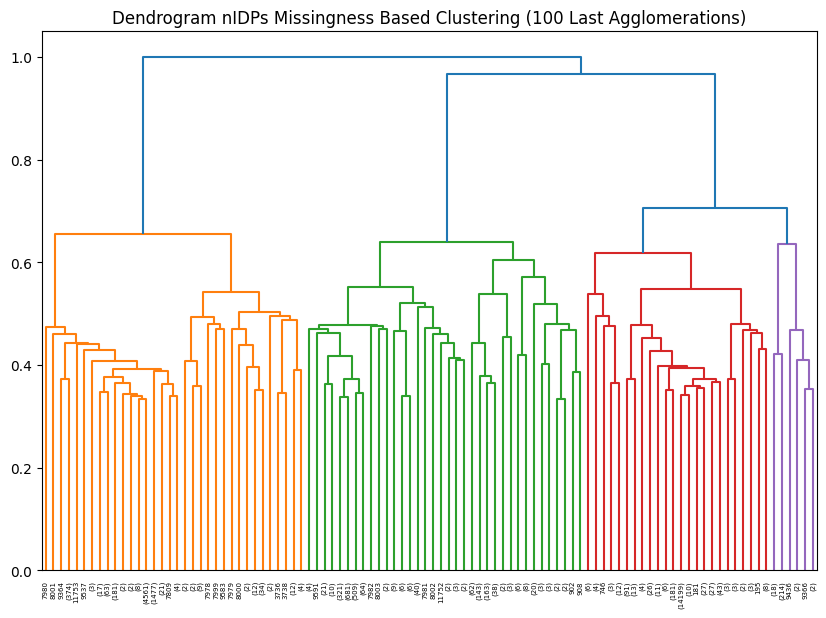

In [12]:
#100 last agglomerations

plt.figure(figsize=(10, 7))  
plt.title("Dendrogram nIDPs Missingness Based Clustering (100 Last Agglomerations)")  
den = dendrogram(link_miss_based , p=100, truncate_mode = 'lastp')
fig = plt.gcf()
fig.savefig(base_directory + '/dendrogram_100.png' , bbox_inches = 'tight', dpi = 300)

In [13]:
#Number of clusters and variables as well as minimal cluster size (optional)

N_clus = 4

N_feats = miss_based_dist.shape[0]

min_clus = 0

In [14]:
#Map to match cluster labels found by algorithm to the notation used in paper

clus_miss_based = AgglomerativeClustering(n_clusters = N_clus , affinity = 'precomputed' , linkage = 'complete')

clus_miss_based.fit(miss_based_dist)


AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=4)

In [15]:
#Separating clusters that are above the minimal limit

block_clus_list = []

block_clus_size = []

misc_clus_list = []

for k in range(N_clus):
    clus_size = sum(clus_miss_based.labels_ == k)
    if clus_size >= min_clus:
        block_clus_list.append(k)
        block_clus_size.append(clus_size)
    else:
        misc_clus_list.append(k)

In [16]:
#Percentage of features covered by our clusters above the minimal size

sum(block_clus_size)/X.shape[1]

1.0

In [17]:
#Identifying cluster containing baseline variables (assumed to be the largest cluster)

baseline_clus = np.argmax(block_clus_size)

In [18]:
#Creating map between the subset of clusters identified and their new labels (ordered by size)

clus_map = np.argsort(-np.array(block_clus_size))

In [19]:
#creating a map between raw and and new cluster labels

raw_to_red = dict()

red_to_raw = dict()

for k in range(len(block_clus_list)):
    raw_to_red[block_clus_list[k]] = np.argmax(clus_map == k)
    red_to_raw[np.argmax(clus_map == k)] = block_clus_list[k]

In [20]:
#Number of variables by cluster

clus_miss_based = AgglomerativeClustering(n_clusters = N_clus , affinity = 'precomputed' , linkage = 'complete')

clus_miss_based.fit(miss_based_dist)

for k in range(len(block_clus_list)):
    n_feats = sum(clus_miss_based.labels_ == block_clus_list[clus_map[k]])
    file_name = base_directory+'/n_feats_clus'+str(k)+'.csv'
    np.savetxt(file_name , np.array([n_feats]) , delimiter = ',')
    print('Number of features in cluster '+str(k)+': ' + str(n_feats))

Number of features in cluster 0: 14685
Number of features in cluster 1: 6805
Number of features in cluster 2: 2143
Number of features in cluster 3: 238


In [21]:
#Number of binary variables by cluster

for k in range(len(block_clus_list)):
    n_bin_feats = int(sum(binary_feats[clus_miss_based.labels_ == block_clus_list[clus_map[k]]]))
    file_name = base_directory+'/n_bin_feats_clus'+str(k)+'.csv'
    np.savetxt(file_name , np.array([n_bin_feats]) , delimiter = ',') 
    print('Number of binary features in cluster '+str(k)+': ' + str(n_bin_feats))

Number of binary features in cluster 0: 13458
Number of binary features in cluster 1: 371
Number of binary features in cluster 2: 131
Number of binary features in cluster 3: 3


In [22]:
#sort labels cluster-wise
new_order_miss_based = leaves_list(link_miss_based)

miss_based_dist_new = miss_based_dist[new_order_miss_based , :][: , new_order_miss_based]

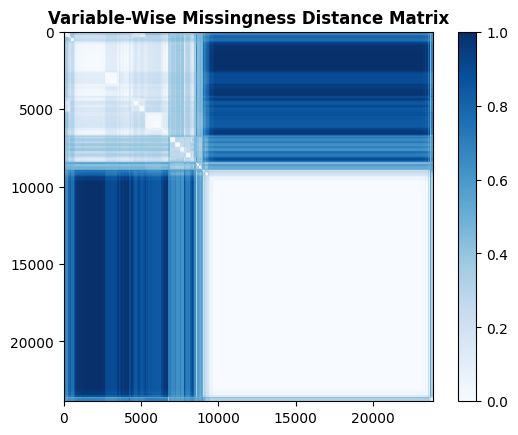

In [23]:
#full missingness based matrix
img = plt.imshow(miss_based_dist_new, alpha=1, cmap='Blues' , vmin = 0, vmax = 1 )

plt.colorbar(img)


plt.title('Variable-Wise Missingness Distance Matrix', fontweight ="bold")
fig = plt.gcf()
fig.savefig(base_directory + '/miss-based-matrix.png' , bbox_inches = 'tight', dpi = 300)
plt.show()



In [24]:
#Keeping track of new ordering by order of agglomeration

current = -1
cluster_labels = []
limit_list = []
for i in range(len(clus_miss_based.labels_)):
    if clus_miss_based.labels_[new_order_miss_based[i]] != current:
        current = clus_miss_based.labels_[new_order_miss_based[i]]
        limit_list.append(i)
        cluster_labels.append(current)
limit_list.append(len(clus_miss_based.labels_))

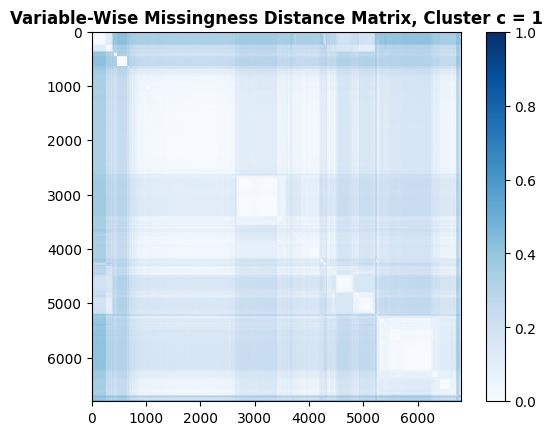

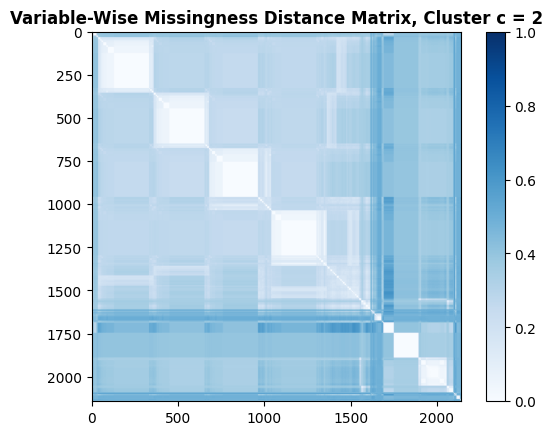

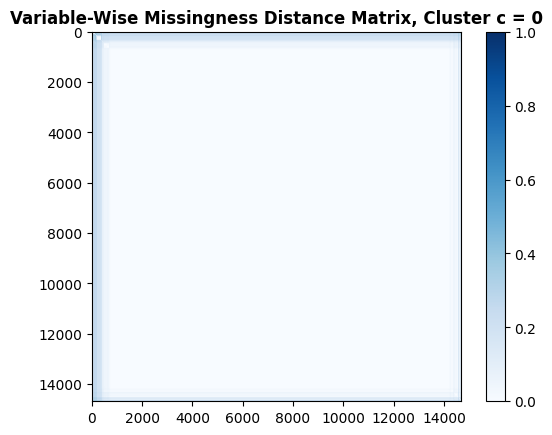

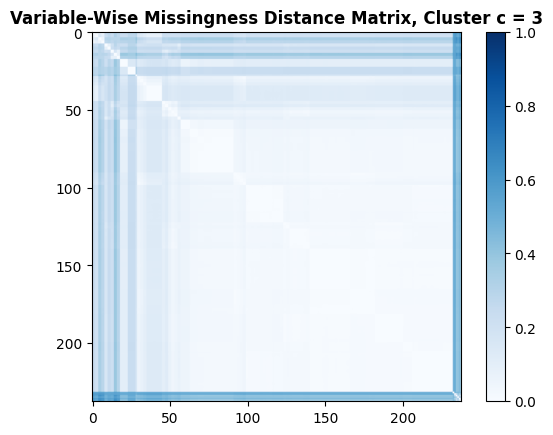

In [25]:
#Creating heat maps of variable-wise missingness distance matrix

for k in range(N_clus):
    if clus_miss_based.labels_[new_order_miss_based[limit_list[k]]] in block_clus_list:
        img = plt.imshow(miss_based_dist_new[limit_list[k]:limit_list[k+1],:][:,limit_list[k]:limit_list[k+1]], alpha=1, cmap='Blues' , vmin = 0, vmax = 1 )
        plt.colorbar(img)
        plt.title('Variable-Wise Missingness Distance Matrix, Cluster c = '+str(raw_to_red[clus_miss_based.labels_[new_order_miss_based[limit_list[k]]]]), fontweight ="bold")
        fig = plt.gcf()
        fig.savefig(base_directory + '/miss-matrices/miss-matrix-clus'+ str(raw_to_red[clus_miss_based.labels_[new_order_miss_based[limit_list[k]]]]) +'.png' , bbox_inches = 'tight', dpi = 300)
        plt.show()
    

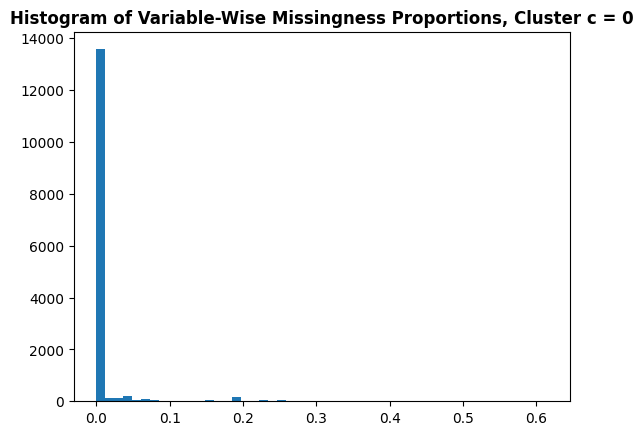

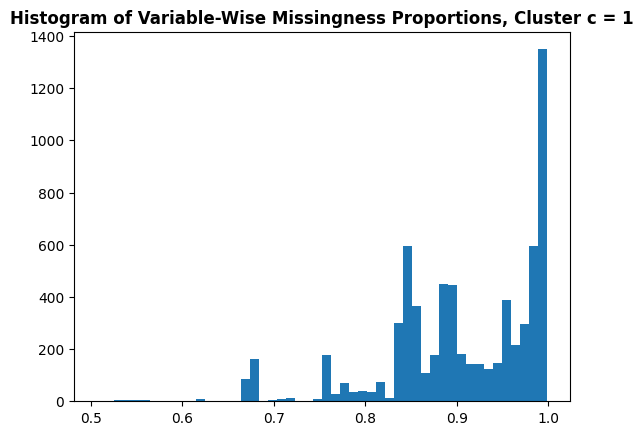

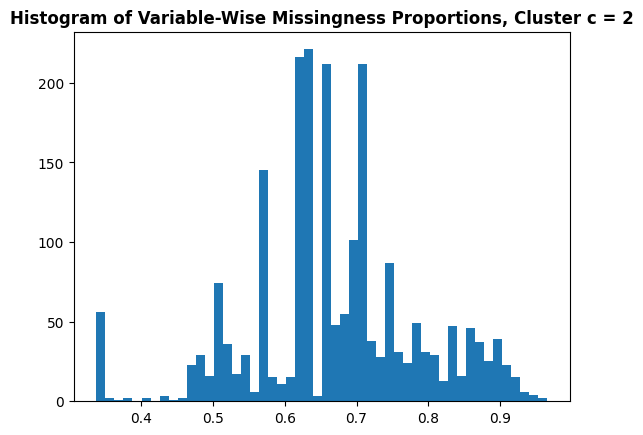

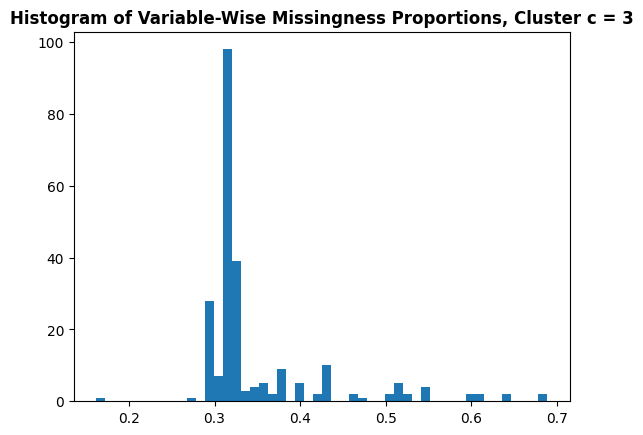

In [26]:
#Creating histograms of missingness proportions by variable

for k in range(len(block_clus_list)):
    prop_miss = np.isnan(X[:, clus_miss_based.labels_== red_to_raw[k]]).mean(axis = 0)
    img =plt.hist(prop_miss , bins = 50)
    plt.title('Histogram of Variable-Wise Missingness Proportions, Cluster c = '+str(k), fontweight ="bold")
    fig = plt.gcf()
    fig.savefig(base_directory + '/histograms/hist-miss-clus'+ str(k)+'.png' , bbox_inches = 'tight', dpi = 300)
    plt.show()

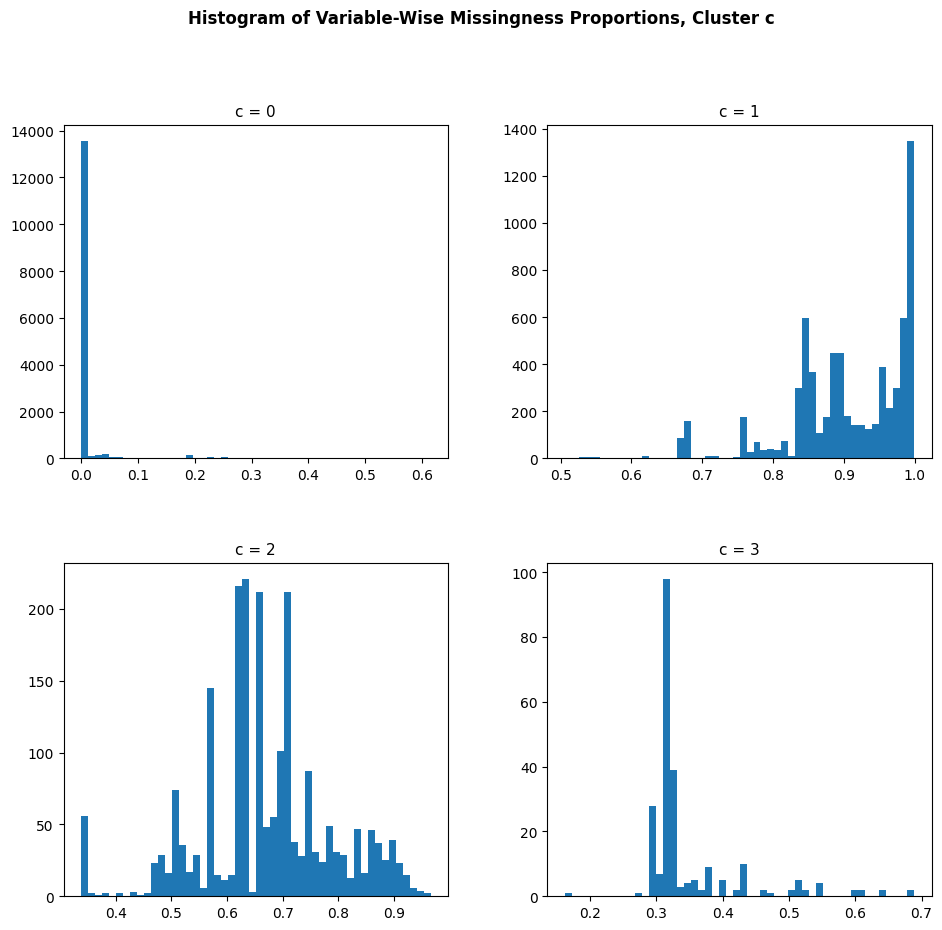

In [27]:
#Creating histograms of missingness proportions by variable, combined figure


figr, axs = plt.subplots(2, 2)
figr.suptitle('Histogram of Variable-Wise Missingness Proportions, Cluster c', fontweight ="bold")
figr.tight_layout(pad = 1.5)
for i in range(2):
    for j in range(2):
        k =2*i + j
        prop_miss = np.isnan(X[:, clus_miss_based.labels_== red_to_raw[k]]).mean(axis = 0)
        axs[i,j].hist(prop_miss , bins = 50)
        axs[i,j].set_title('c = '+str(k) , fontdict = {'fontsize':11})
figr.set_size_inches(10, 10)
fig = plt.gcf()
fig.savefig(base_directory + '/histograms/hist-miss-comb.png' , bbox_inches = 'tight', dpi = 300)
plt.show()

In [28]:
#Creating Condensed Versions of correlation and number of samples matrix

raw_corr_mat_cond = squareform(raw_corr_mat, checks = False)

sample_matrix_cond = squareform(sample_matrix, checks = False)

In [29]:
#Setting FDR corrected non-significant correlations to 0

abs_t_stats = np.abs(raw_corr_mat_cond*np.sqrt(sample_matrix_cond-2)/np.sqrt(1-raw_corr_mat_cond**2))

dfs = sample_matrix_cond-2

p_vals = 2*(1-t.cdf(abs_t_stats , df = dfs))

p_vals_adj = fdrcorrection(p_vals , method = 'p')[1]



In [30]:
#Setting non-significant correlations to 0

corr_mat_adj_cond = raw_corr_mat_cond

corr_mat_adj_cond[p_vals_adj > 0.05] = 0

corr_mat_adj = squareform(corr_mat_adj_cond , checks = False)

corr_mat_adj[np.diag_indices(corr_mat_adj.shape[0])] = 1

In [31]:
#Reordering variables in correlation matrix by order of agglomeration

corr_mat_adj_new = corr_mat_adj[new_order_miss_based , :][: , new_order_miss_based]

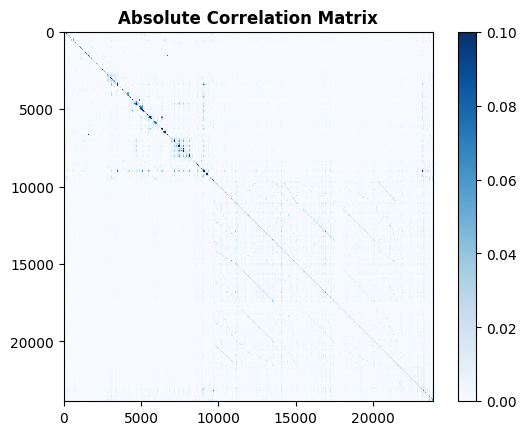

In [32]:
#full correlation based distance matrix
img = plt.imshow(corr_mat_adj_new, alpha=1, cmap='Blues' , vmin = 0, vmax = 0.1 )

plt.colorbar(img)

plt.title('Absolute Correlation Matrix', fontweight ="bold")
fig = plt.gcf()
fig.savefig(base_directory + '/corr-matrix.png' , bbox_inches = 'tight', dpi = 300)
plt.show()

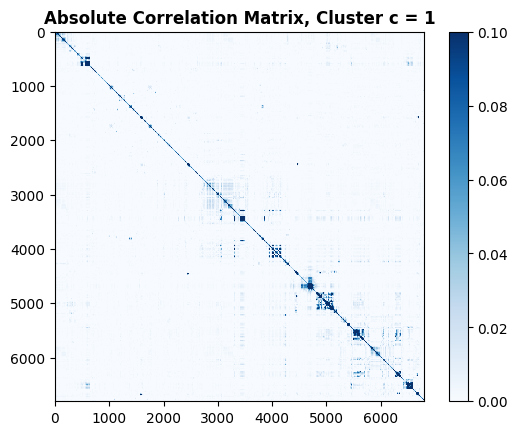

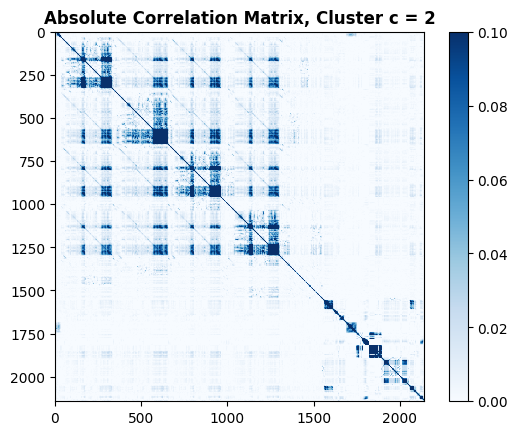

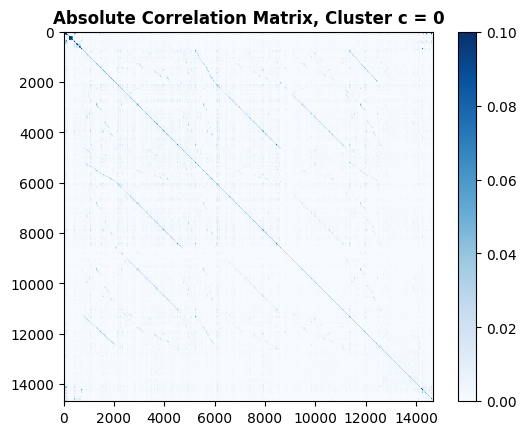

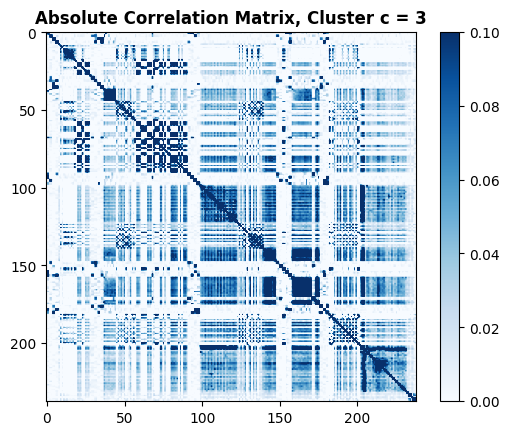

In [33]:
#Creating heat maps of correlation matrices

for k in range(N_clus):
    if clus_miss_based.labels_[new_order_miss_based[limit_list[k]]] in block_clus_list:
        img = plt.imshow(corr_mat_adj_new[limit_list[k]:limit_list[k+1],:][:,limit_list[k]:limit_list[k+1]], alpha=1, cmap='Blues' , vmin = 0, vmax = 0.1)
        plt.colorbar(img)
        plt.title('Absolute Correlation Matrix, Cluster c = '+str(raw_to_red[clus_miss_based.labels_[new_order_miss_based[limit_list[k]]]]), fontweight ="bold")
        fig = plt.gcf()
        fig.savefig(base_directory + '/corr-matrices/corr-matrix-clus'+ str(raw_to_red[clus_miss_based.labels_[new_order_miss_based[limit_list[k]]]])+'.png' , bbox_inches = 'tight', dpi = 300)
        plt.show()
    

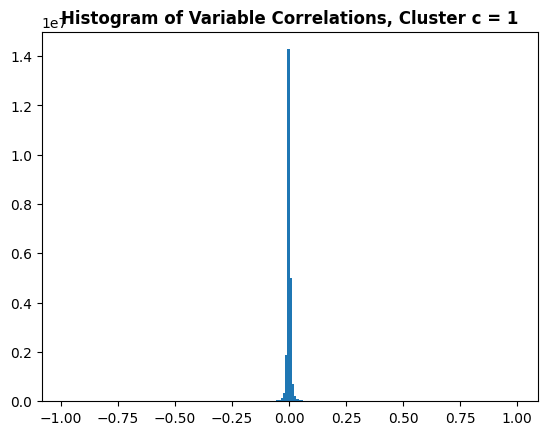

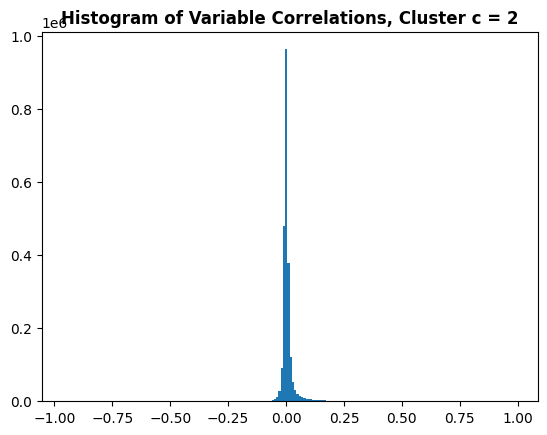

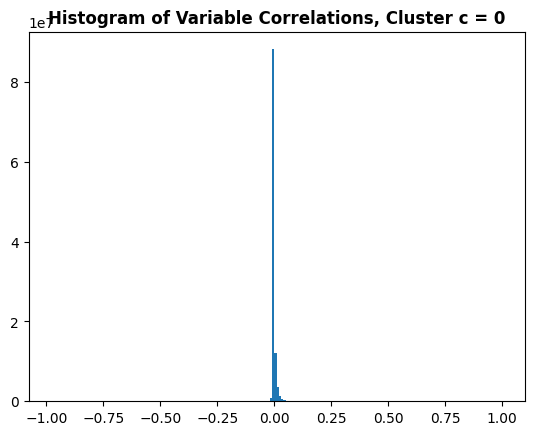

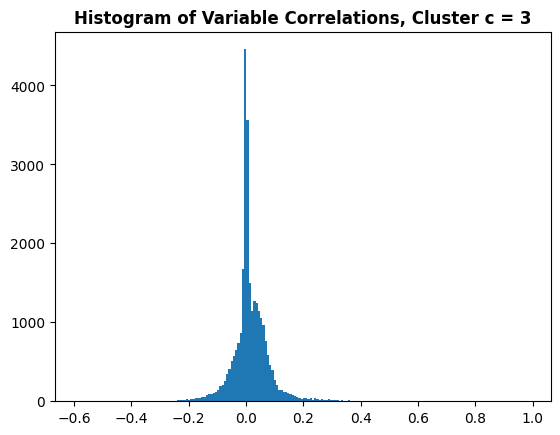

In [34]:
#Creating histograms correlations

for k in range(N_clus):
    if clus_miss_based.labels_[new_order_miss_based[limit_list[k]]] in block_clus_list:
        corr_based_dist_cond_seg = scipy.spatial.distance.squareform(corr_mat_adj_new[limit_list[k]:limit_list[k+1],:][:,limit_list[k]:limit_list[k+1]] , force = 'tovector' , checks = False)
        img =plt.hist(corr_based_dist_cond_seg , bins = 200)
        plt.title('Histogram of Variable Correlations, Cluster c = '+str(raw_to_red[clus_miss_based.labels_[new_order_miss_based[limit_list[k]]]]), fontweight ="bold")
        fig = plt.gcf()
        fig.savefig(base_directory +'/histograms/hist-corr-clus'+ str(raw_to_red[clus_miss_based.labels_[new_order_miss_based[limit_list[k]]]])+'.png' , bbox_inches = 'tight', dpi = 300)
        plt.show()

In [35]:
#Percentage of variables in cluster c=0 with no missingness

prop_miss = np.isnan(X[:, clus_miss_based.labels_== red_to_raw[0]]).mean(axis = 0)

print('Proportion of variables in cluster c = 0 that have no missingness: ' + str(np.mean(prop_miss == 0)))

Proportion of variables in cluster c = 0 that have no missingness: 0.910929519918284


In [36]:
#Loading nIDP labels

pickle_in = open('nIDP_labels.pickle','rb')
df_labels = pickle.load(pickle_in)
nIDP_category = df_labels[1]

In [37]:
categories = np.unique(nIDP_category)
heights = [(nIDP_category == categories[k]).mean() for k in range(len(categories))]

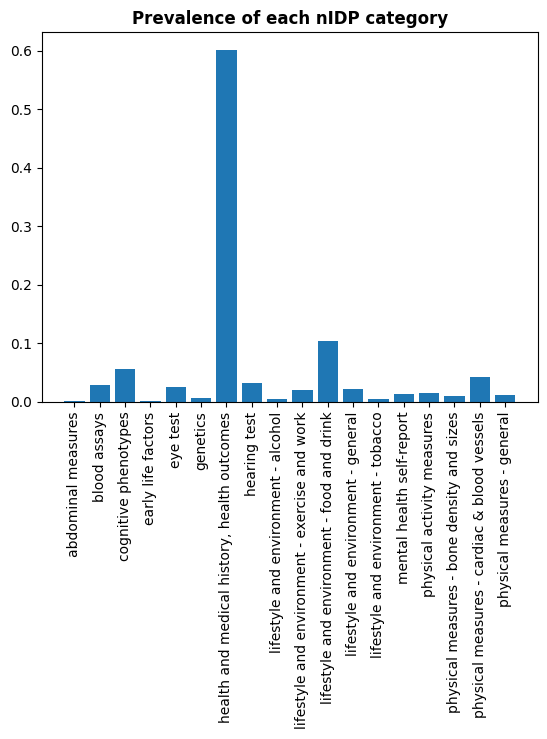

In [38]:
#Bar plots of nIDP categories

fig, ax = plt.subplots()
ax.bar(categories, heights)

plt.xticks(rotation=90)

plt.title('Prevalence of each nIDP category', fontweight ="bold")
fig = plt.gcf()
fig.savefig(base_directory +'/nIDP-prevalence.png' , bbox_inches = 'tight', dpi = 300)
plt.show()

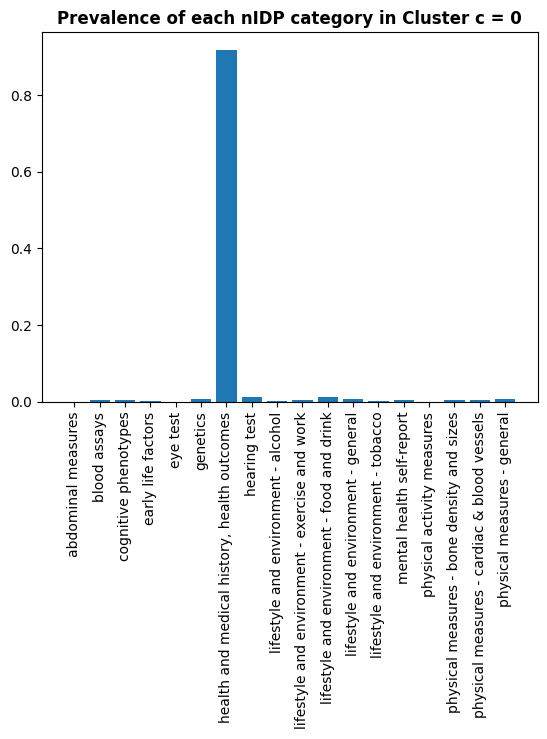

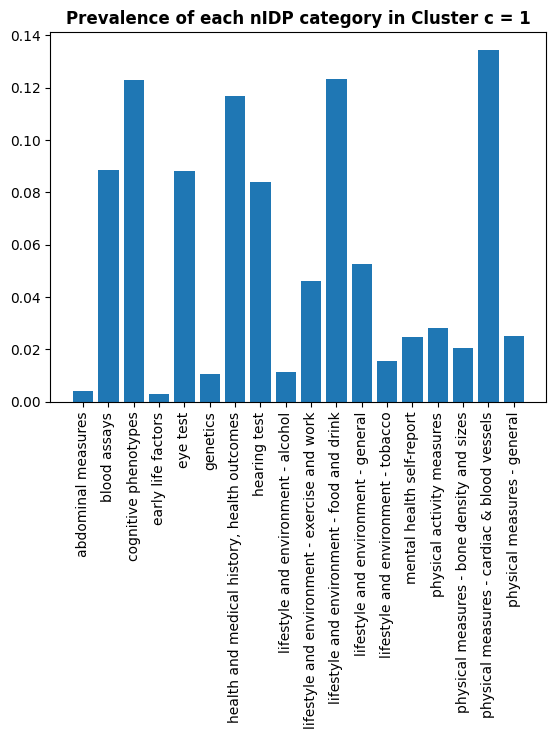

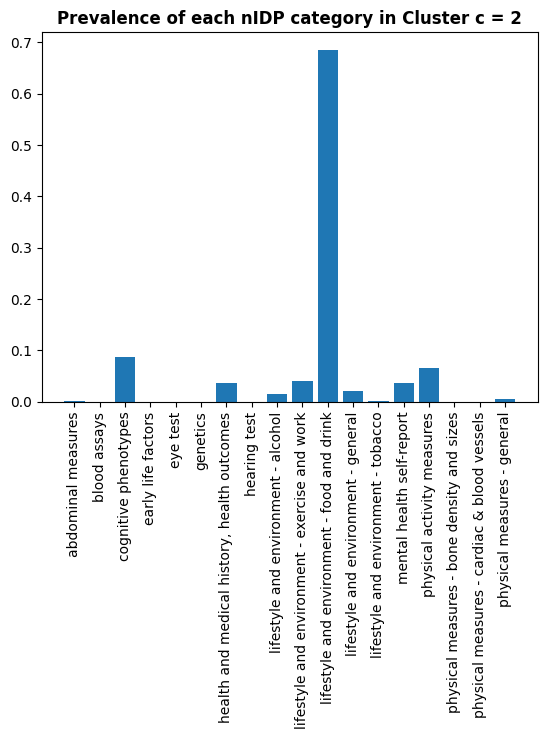

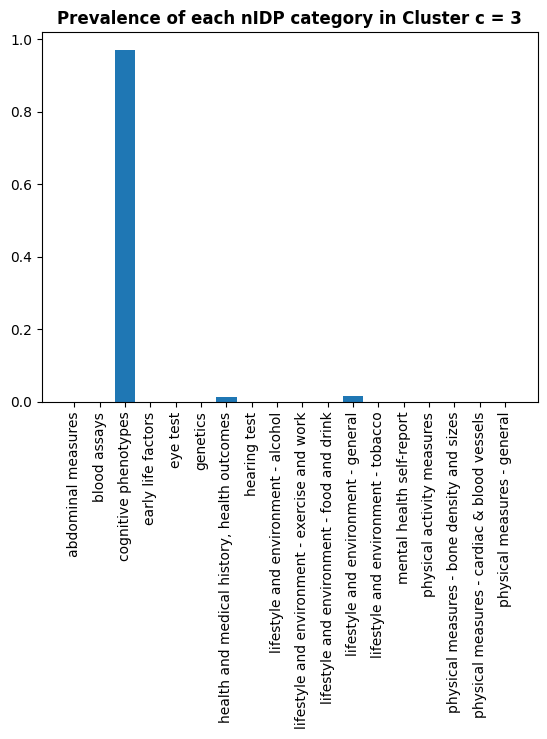

In [39]:
#Bar plots of nIDP categories



for k in range(len(block_clus_list)):
    fig, ax = plt.subplots()
    heights = [(nIDP_category[clus_miss_based.labels_ == red_to_raw[k]] == categories[j]).mean() for j in range(len(categories))]
    ax.bar(categories, heights)

    plt.xticks(rotation=90)

    plt.title('Prevalence of each nIDP category in Cluster c = '+str(k), fontweight ="bold")
    fig = plt.gcf()
    fig.savefig(base_directory +'/bar-plots/nIDP-prevalence-clus'+ str(k)+'.png' , bbox_inches = 'tight', dpi = 300)
    plt.show()

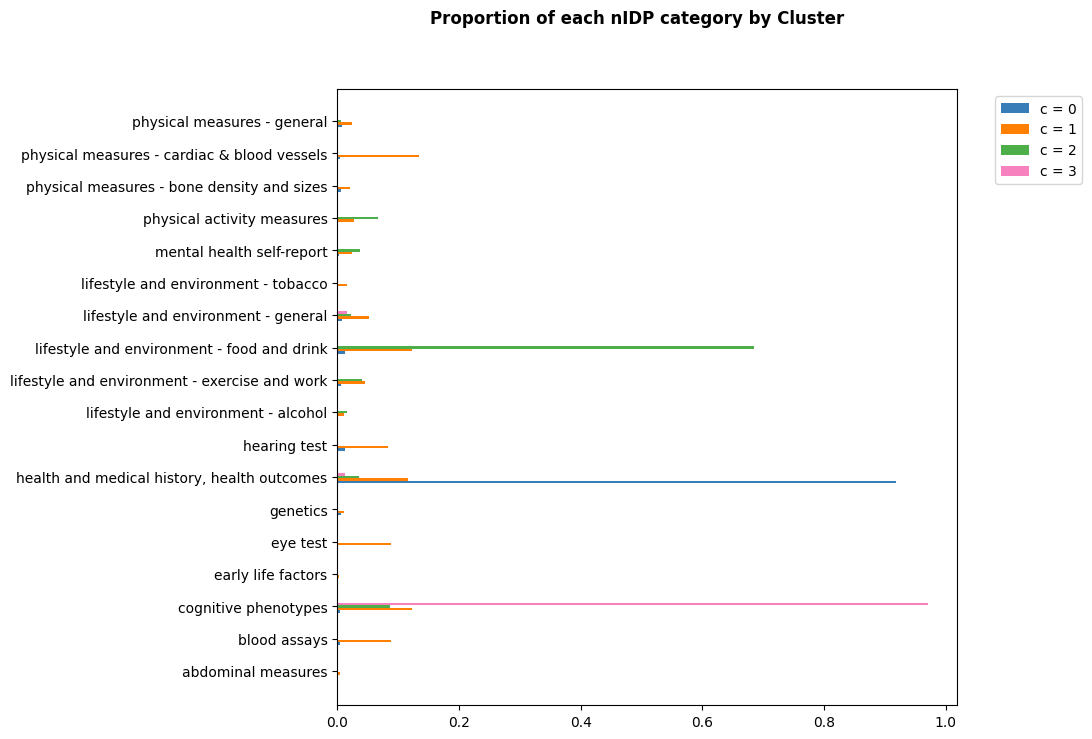

In [40]:
#Bar plots of nIDP categories



figr, axs = plt.subplots(figsize = (8,8))
figr.suptitle('Proportion of each nIDP category by Cluster', fontweight ="bold")

delta = 0.3



positions = np.array(range(categories.shape[0]))*4

my_dictionary = dict()

for k in range(len(block_clus_list)):
        heights = [(nIDP_category[clus_miss_based.labels_ == red_to_raw[k]] == categories[l]).mean() for l in range(len(categories))]
        
        if np.max(heights) < 0.6:
            if -1 not in my_dictionary.keys():
                my_dictionary[-1] = []
            my_dictionary[-1].append(k)
        else:
            if np.argmax(heights) not in my_dictionary.keys():
                my_dictionary[np.argmax(heights)] = []
            my_dictionary[np.argmax(heights)].append(k)
            
for my_key in my_dictionary.keys():
    heights = np.zeros(len(categories))
    for k in my_dictionary[my_key]:
        heights = heights + np.array([(nIDP_category[clus_miss_based.labels_ == red_to_raw[k]] == categories[l]).sum() for l in range(len(categories))])
    heights = heights/heights.sum()
    my_label = 'c = '+ str(my_dictionary[my_key][0])
    if len(my_dictionary[my_key]) > 1:
        for k in range(1,len(my_dictionary[my_key])):
            my_label = my_label + ','+str(my_dictionary[my_key][k])
    axs.barh(positions + delta*k , heights , delta ,label = my_label , color = my_CB_cols[my_dictionary[my_key][0]])
axs.set_yticks(positions + len(my_dictionary.keys())/2*delta, categories)
# plt.xticks(rotation=90)
axs.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig = plt.gcf()
fig.savefig(base_directory + '/bar-plots/nIDP-prevalence-comb.png' , bbox_inches = 'tight', dpi = 300)
plt.show()

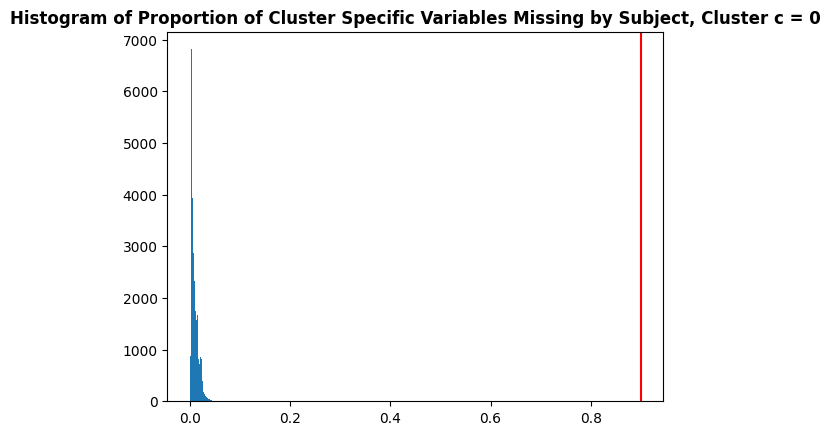

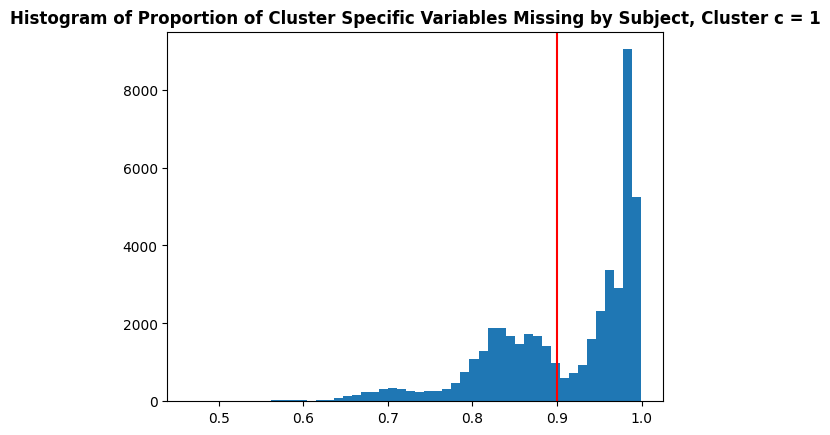

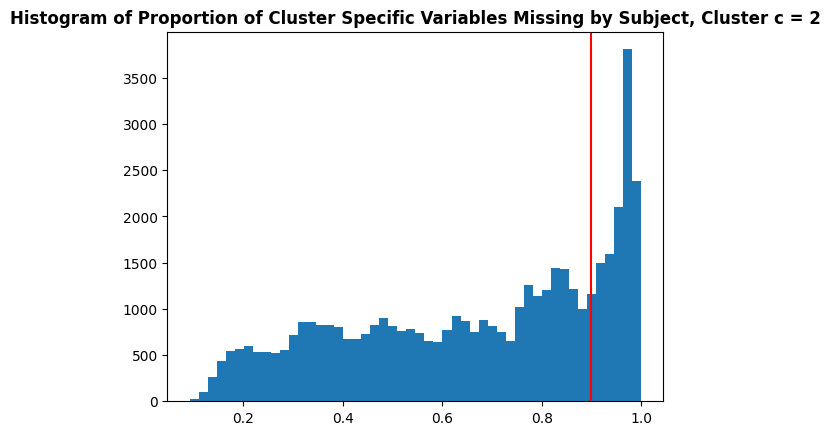

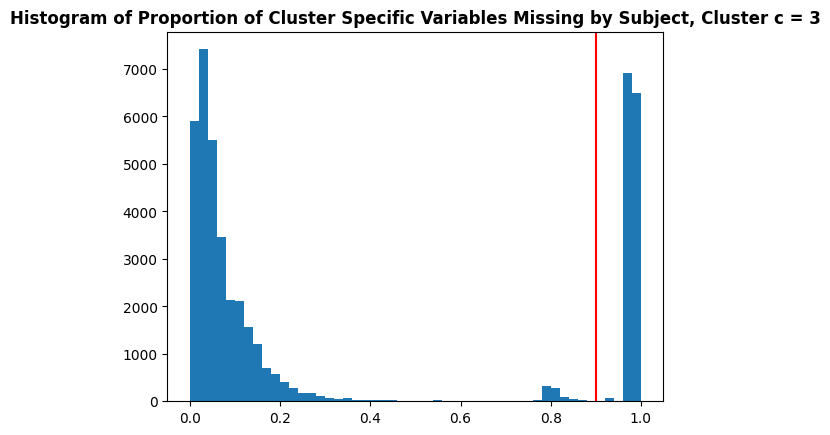

In [41]:
#Identifying Blocks of missing data

for k in range(len(block_clus_list)):
    prop_miss_features = np.isnan(X[:, clus_miss_based.labels_== red_to_raw[k]]).mean(axis = 1)
    img =plt.hist(prop_miss_features , bins = 50)
    plt.title('Histogram of Proportion of Cluster Specific Variables Missing by Subject, Cluster c = '+str(k), fontweight ="bold")
    plt.axvline(x = 0.90 , color = 'red')
    fig = plt.gcf()
    fig.savefig(base_directory + '/histograms/hist-miss-feat-clus'+ str(k)+'.png' , bbox_inches = 'tight', dpi = 300)
    plt.show()

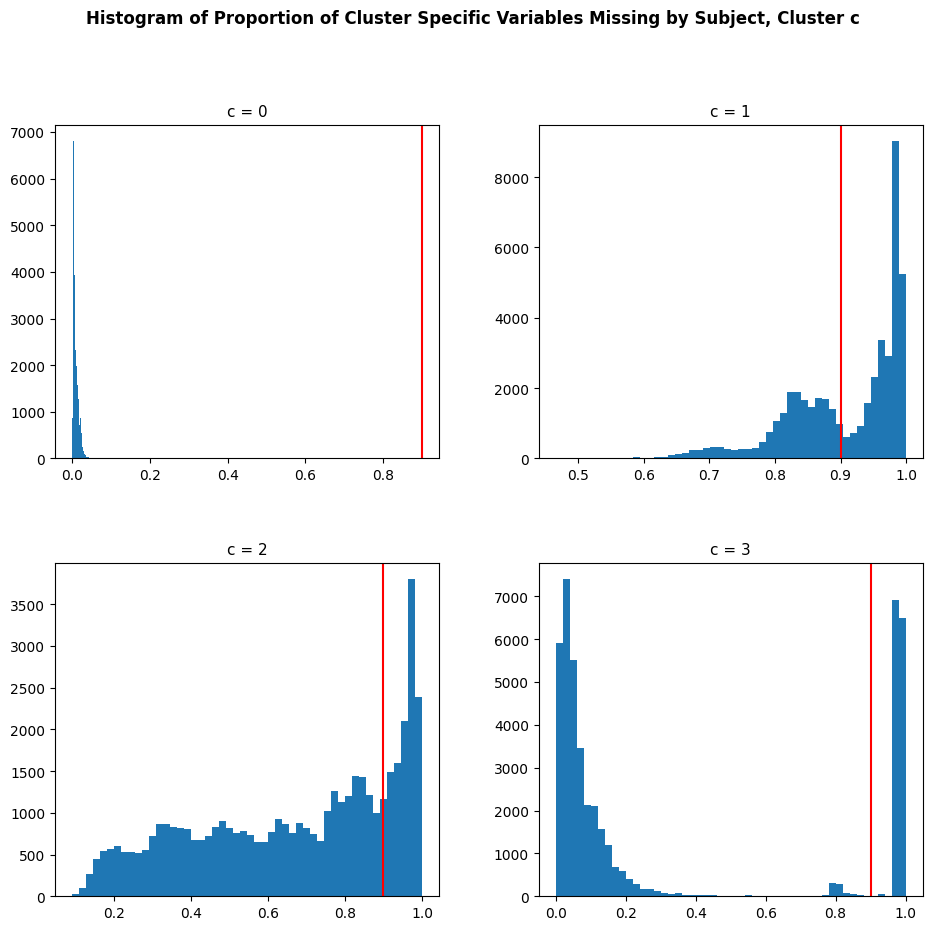

In [42]:
figr, axs = plt.subplots(2, 2)
figr.suptitle('Histogram of Proportion of Cluster Specific Variables Missing by Subject, Cluster c', fontweight ="bold")
figr.tight_layout(pad = 1.5)
for i in range(2):
    for j in range(2):
        k = 2*i + j
        prop_miss_features = np.isnan(X[:, clus_miss_based.labels_== red_to_raw[k]]).mean(axis = 1)
        axs[i,j].hist(prop_miss_features , bins = 50)
        axs[i,j].axvline(x = 0.90 , color = 'red')
        axs[i,j].set_title('c = '+str(k) , fontdict = {'fontsize':11})
figr.set_size_inches(10, 10)
fig = plt.gcf()
fig.savefig(base_directory + '/histograms/hist-miss-feat-comb.png' , bbox_inches = 'tight', dpi = 300)
plt.show()

In [43]:
#identifying Block Sizes

for k in range(len(block_clus_list)):
    prop_miss_features = np.isnan(X[:, clus_miss_based.labels_== red_to_raw[k]]).mean(axis = 1)
    prop_block = (prop_miss_features>0.90).mean()
    file_name = base_directory+'/prop_block_clus'+str(k)+'.csv'
    np.savetxt(file_name , np.array([prop_block]) , delimiter = ',')
    print('Block in Cluster ' + str(k)+ ' is ' + str(int(round(100*prop_block))) +'% of all subjects.')
    

Block in Cluster 0 is 0% of all subjects.
Block in Cluster 1 is 58% of all subjects.
Block in Cluster 2 is 26% of all subjects.
Block in Cluster 3 is 29% of all subjects.


In [44]:
#Calculating parameters for salt and pepper missingness

for k in range(len(block_clus_list)):
    prop_miss_features = np.isnan(X[:, clus_miss_based.labels_== red_to_raw[k]]).mean(axis = 1)
    prop_miss = np.isnan(X[:, clus_miss_based.labels_== red_to_raw[k]][prop_miss_features < 0.90 , :]).mean(axis = 0)
    print(prop_miss.shape)
    pd.DataFrame(prop_miss).to_csv(current_directory + '/props_US_miss_clus'+str(k)+'.csv')
    my_mean = prop_miss.mean()
    my_var = prop_miss.var()
    my_alpha = ((1-my_mean)*my_mean/my_var-1)*my_mean
    my_beta = ((1-my_mean)*my_mean/my_var-1)*(1-my_mean)
    file_name = base_directory + '/alpha_clus'+str(k)+'.csv'
    np.savetxt(file_name , np.array([my_alpha]) , delimiter = ',')
    file_name = base_directory + '/beta_clus'+str(k)+'.csv'
    np.savetxt(file_name , np.array([my_beta]) , delimiter = ',')
    print('Cluster ' + str(k)+':')
    print('MME of alpha is '+str(my_alpha))
    print('MME of beta is '+str(my_beta))

(14685,)
Cluster 0:
MME of alpha is 0.03777987715109385
MME of beta is 4.161965687301928
(6805,)
Cluster 1:
MME of alpha is 4.1363907913772495
MME of beta is 0.9138444144970509
(2143,)
Cluster 2:
MME of alpha is 6.000467477759117
MME of beta is 4.5712485941587895
(238,)
Cluster 3:
MME of alpha is 0.4378879194526773
MME of beta is 4.449000648089287


In [45]:
#Finding mean absolute correlation between each pair of clusters

for k1 in range(len(block_clus_list) - 1):
    for k2 in range(k1+1,len(block_clus_list)):
        print('Average absolute correlation between clusters '+str(k1)+' and '+str(k2)+': '+str(np.abs(corr_mat_adj[clus_miss_based.labels_ == red_to_raw[k1] , :][: , clus_miss_based.labels_ == red_to_raw[k2]]).mean()))
        
        
        

Average absolute correlation between clusters 0 and 1: 0.0032326149779405506
Average absolute correlation between clusters 0 and 2: 0.003928823622570768
Average absolute correlation between clusters 0 and 3: 0.004452372010823076
Average absolute correlation between clusters 1 and 2: 0.005135858900239306
Average absolute correlation between clusters 1 and 3: 0.0049708208303939575
Average absolute correlation between clusters 2 and 3: 0.005918565000963021


In [46]:
#Finding top 10% of absolute correlation between each pair of clusters


for k1 in range(len(block_clus_list) - 1):
    for k2 in range(k1+1,len(block_clus_list)):
        print('Top 10% of absolute correlation between clusters '+str(k1)+' and '+str(k2)+': '+str(np.quantile(np.abs(corr_mat_adj[clus_miss_based.labels_ == red_to_raw[k1] , :][: , clus_miss_based.labels_ == red_to_raw[k2]]) , q =0.9)))
        
        

Top 10% of absolute correlation between clusters 0 and 1: 0.008121468789973562
Top 10% of absolute correlation between clusters 0 and 2: 0.00835154545014716
Top 10% of absolute correlation between clusters 0 and 3: 0.009307021068491394
Top 10% of absolute correlation between clusters 1 and 2: 0.010634479137060003
Top 10% of absolute correlation between clusters 1 and 3: 0.010522419566736146
Top 10% of absolute correlation between clusters 2 and 3: 0.011869432147305233


In [47]:
#Finding mean absolute correlation within each cluster


for k in range(len(block_clus_list)):
        print('Average absolute correlation within cluster '+str(k)+': '+str(np.abs(squareform(corr_mat_adj[clus_miss_based.labels_ == red_to_raw[k] , :][: , clus_miss_based.labels_ == red_to_raw[k]], checks =False)).mean()))

Average absolute correlation within cluster 0: 0.003198100628463161
Average absolute correlation within cluster 1: 0.007751389891200109
Average absolute correlation within cluster 2: 0.015624167967651776
Average absolute correlation within cluster 3: 0.04579265467223612


In [48]:
#Finding top 10% absolute correlation within each cluster

for k in range(len(block_clus_list)):
    
    
    
        
        
        print('Top 10% of absolute correlation '+str(k)+': '+str(np.quantile(np.abs(squareform(corr_mat_adj[clus_miss_based.labels_ == red_to_raw[k] , :][: , clus_miss_based.labels_ == red_to_raw[k]], checks =False)) , q=0.90)))
              
              
              
              
              

Top 10% of absolute correlation 0: 0.007144693027955548
Top 10% of absolute correlation 1: 0.013006356835749258
Top 10% of absolute correlation 2: 0.027551966182323497
Top 10% of absolute correlation 3: 0.10258945675368597


In [49]:
#setting clusters for analysis and determining granularity of histagram

analysis_clus = [2,3]

nbins_one_side = 500

In [50]:
#Creating histograms of correlations within clusters



for k in analysis_clus:
    my_hist = np.full(shape=(1+2*nbins_one_side ,) , fill_value=0.0)
    corr_mat_cont_adj_cond = scipy.spatial.distance.squareform(corr_mat_adj[np.logical_and(clus_miss_based.labels_ == red_to_raw[k] , binary_feats == False) , :][: , np.logical_and(clus_miss_based.labels_ == red_to_raw[k] , binary_feats == False)] , checks = False)
    n_corrs = corr_mat_cont_adj_cond.shape[0]
    for corr_val in corr_mat_cont_adj_cond:
        my_int = round(np.abs(nbins_one_side*corr_val))
        my_hist[int(nbins_one_side + my_int*np.sign(corr_val))] += 1/n_corrs
    pd.DataFrame(my_hist).to_csv(base_directory + '/histogram_corr_within_clus'+str(k)+'.csv')



In [51]:
for k1 in analysis_clus:
    for k2 in analysis_clus:
        if k1 < k2:
            my_hist = np.full(shape=(1+2*nbins_one_side ,) , fill_value=0.0)
            corr_mat_cont_adj_cond = corr_mat_adj[np.logical_and(clus_miss_based.labels_ == red_to_raw[k1] , binary_feats == False) , :][: , np.logical_and(clus_miss_based.labels_ == red_to_raw[k2] , binary_feats == False)].reshape(-1)
            n_corrs = corr_mat_cont_adj_cond.shape[0]
            for corr_val in corr_mat_cont_adj_cond:
                my_int = round(np.abs(nbins_one_side*corr_val))
                my_hist[int(nbins_one_side + my_int*np.sign(corr_val))] += 1/n_corrs
            pd.DataFrame(my_hist).to_csv(base_directory + '/histogram_corr_between_clus_'+str(k1)+'_'+str(k2)+'.csv')

In [52]:
#Imputing the tiny ammounts of missingness left in the baseline cluster

no_miss_clus = red_to_raw[0]

X_no_missing = X[:, clus_miss_based.labels_== no_miss_clus]

inds_no_var = X_no_missing.std(axis = 0) == 0

X_no_missing =  X_no_missing[: , inds_no_var == False]


binary_feats_no_missing = np.empty((X_no_missing.shape[1],))

binary_feats_no_missing[:] = False

for j in range(X_no_missing.shape[1]):
    if np.all(np.logical_or(np.isnan(X_no_missing[:,j]) , np.logical_or(X_no_missing[:,j]==0 , X_no_missing[:,j]==1))):
        binary_feats_no_missing[j] = True


X_no_missing[: , binary_feats_no_missing == False] = SimpleImputer(strategy = 'mean').fit_transform(X_no_missing[: , binary_feats_no_missing == False])

X_no_missing[: , binary_feats_no_missing == True] = SimpleImputer(strategy = 'most_frequent').fit_transform(X_no_missing[: , binary_feats_no_missing == True])

X_no_missing[: , binary_feats_no_missing == False] = (X_no_missing[: , binary_feats_no_missing == False]- X_no_missing[: , binary_feats_no_missing == False].mean(axis = 0))/X_no_missing[: , binary_feats_no_missing == False].std(axis = 0)

In [53]:
#saving the structured missingness by subject

clus_block_dict = {}

for k in analysis_clus:
        clus_block_dict[k] = np.isnan(X[:, clus_miss_based.labels_== red_to_raw[k]]).mean(axis = 1) > 0.90

In [54]:
#Fitting logistic model for predicting block membership 

model_dict = dict()

for k in analysis_clus:
    my_lambda = pd.read_csv(base_directory+'/lambda_clus'+str(k)+'.csv').iloc[0,1]
    model_dict[k] = LogisticRegression(C = np.exp(-my_lambda) , verbose = 1 , penalty = 'l1' , solver = 'liblinear').fit(X_no_missing, clus_block_dict[k])
    

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 4
iter   6  #CD cycles 1
iter   7  #CD cycles 4
iter   8  #CD cycles 1
iter   9  #CD cycles 40
iter  10  #CD cycles 3
iter  11  #CD cycles 3
iter  12  #CD cycles 1
iter  13  #CD cycles 27
iter  14  #CD cycles 2
iter  15  #CD cycles 1
iter  16  #CD cycles 42
optimization finished, #iter = 16
Objective value = 62.580704
#nonzeros/#features = 68/14261
[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 3
iter   5  #CD cycles 1
iter   6  #CD cycles 7
iter   7  #CD cycles 1
iter   8  #CD cycles 11
iter   9  #CD cycles 1
iter  10  #CD cycles 28
iter  11  #CD cycles 3
iter  12  #CD cycles 1
iter  13  #CD cycles 38
iter  14  #CD cycles 2
iter  15  #CD cycles 1
iter  16  #CD cycles 35
optimization finished, #iter = 16
Objective value = 56.724294
#nonzeros/#features = 84/14261


In [55]:
#Finding number of important variables for each cluster

for k in analysis_clus:
    print('Number of important variables for cluster '+ str(k)+ ': '+str((model_dict[k].coef_ != 0).reshape(-1).sum()))

Number of important variables for cluster 2: 67
Number of important variables for cluster 3: 83


In [56]:
#Finding number of important binary variables for each cluster cluster

for k in analysis_clus:
    print('Number of important binary variables for cluster '+str(k)+': '+ str(binary_feats_no_missing[(model_dict[k].coef_ != 0).reshape(-1)].sum()))

Number of important binary variables for cluster 2: 5.0
Number of important binary variables for cluster 3: 5.0


In [57]:
for k in analysis_clus:
    my_lambda = pd.read_csv(base_directory+'/lambda_clus'+str(k)+'.csv').iloc[0,1]
    my_logreg = LogisticRegression(C = np.exp(-my_lambda) , verbose = 0 , penalty = 'l1' , solver = 'liblinear')
    my_AUC = cross_val_score(estimator = my_logreg , X=X_no_missing , y = clus_block_dict[k] , cv = 5 , scoring = 'roc_auc').mean()
    pd.DataFrame(np.array([my_AUC])).to_csv(base_directory + '/AUC_clus'+str(k)+'.csv')
    print('5-fold CV AUC Score for Cluster '+str(k)+' is: ' + str(my_AUC))

5-fold CV AUC Score for Cluster 2 is: 0.706622802370332
5-fold CV AUC Score for Cluster 3 is: 0.8567317070362316


In [58]:
#Finding indices of important variables for each cluster

imp_vars_dict = dict()

temp = np.cumsum(inds_no_var == True)[inds_no_var == False]

for k in analysis_clus:
    imp_vars_dict[k] = np.array(range(X_no_missing.shape[1]))[(model_dict[k].coef_ != 0).reshape(-1) == True] + temp[(model_dict[k].coef_ != 0).reshape(-1) == True]


In [59]:
#Finding all indices that constitute important variables

temp = np.array([] , dtype = 'int')

for k in analysis_clus:
    temp = np.concatenate((temp , imp_vars_dict[k]))

all_imp_vars = np.unique(temp)

In [60]:
#Number of core variablse

print('Number of core variables: '+str(all_imp_vars.shape[0]))

Number of core variables: 131


In [61]:
#Saving correlation matrix of important variables

corr_mat_no_miss = corr_mat_adj[:, clus_miss_based.labels_ == no_miss_clus][clus_miss_based.labels_ == no_miss_clus , :]

corr_all_imp_vars = corr_mat_no_miss[: , all_imp_vars][all_imp_vars , :]

pd.DataFrame(corr_all_imp_vars).to_csv(base_directory+'/corr_mat_important_vars'+'.csv')


In [62]:
#Saving positions of important variables for each cluster

for k in analysis_clus:
    indic_clus = np.array([(ind == imp_vars_dict[k]).sum() > 0 for ind in all_imp_vars])
    file_name = base_directory+'/indic_imp_vars_clus'+str(k)+'.csv'
    np.savetxt(file_name, indic_clus , delimiter = ',')


In [63]:
for k in analysis_clus:
    my_hist = np.full(shape=(1+2*nbins_one_side ,) , fill_value=0.0)
    corr_mat_cont_adj_cond = corr_mat_adj[np.logical_and(clus_miss_based.labels_ == red_to_raw[k1] , binary_feats == False) , :][: , all_imp_vars].reshape(-1)
    n_corrs = corr_mat_cont_adj_cond.shape[0]
    for corr_val in corr_mat_cont_adj_cond:
        my_int = round(np.abs(nbins_one_side*corr_val))
        my_hist[int(nbins_one_side + my_int*np.sign(corr_val))] += 1/n_corrs
    pd.DataFrame(my_hist).to_csv(base_directory + '/histogram_corr_between_imp_and_clus_'+str(k)+'.csv')